In [ ]:
import os
import sys
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D, LSTM, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import gensim

In [ ]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
import pandas as pd
df = pd.read_csv("./data.csv")

In [ ]:
df.dropna(subset=['Body'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df['Headline'] = df['Headline'].str.lower()
df['Body'] = df['Body'].str.lower()
df.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,four ways bob corker skewered donald trump,image copyright getty images\non sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,linklater's war veteran comedy speaks to moder...,"london (reuters) - “last flag flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,trump’s fight with corker jeopardizes his legi...,the feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,egypt's cheiron wins tie-up with pemex for mex...,mexico city (reuters) - egypt’s cheiron holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,jason aldean opens 'snl' with vegas tribute,"country singer jason aldean, who was performin...",1


In [ ]:
import string
def remove_punctuations(text):
    punctuations = set(string.punctuation)
    text = str(text)
    # return text.translate(str.maketrans('', '', punctuations))
    return " ".join([word for word in text.split() if word not in punctuations])

df['Headline'] = df['Headline'].apply(lambda x: remove_punctuations(x))
df['Body'] = df['Body'].apply(lambda x: remove_punctuations(x))

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])

df['Headline'] = df['Headline'].apply(lambda x: remove_stopwords(x))
df['Body'] = df['Body'].apply(lambda x: remove_stopwords(x))

In [ ]:
import re
def remove_spl_chars(text):
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

df['Headline'] = df['Headline'].apply(lambda x: remove_spl_chars(x))
df['Body'] = df['Body'].apply(lambda x: remove_spl_chars(x))

In [ ]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer(language='english')
def stem(text):
    stemmed_sentence = " ".join(stemmer.stem(word) for word in text.split())
    return stemmed_sentence

df['Headline'] = df['Headline'].apply(lambda x: stem(x))
df['Body'] = df['Body'].apply(lambda x: stem(x))

In [ ]:
texts = []
labels = []
for i in range(3988):
    texts.append(df['Body'][i])
    labels.append(df['Label'][i])

print(len(texts))
len(labels)

3988


3988

In [ ]:
!python -m spacy download en_core_web_lg

2023-12-31 12:41:57.095038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 12:41:57.095171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 12:41:57.139993: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-31 12:42:00.897068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [ ]:
def prep_vect(text):
    doc = nlp(text)

    filtered_tokens = []
    for token in doc:
        if token.is_punct or token.is_stop:
            continue
        filtered_tokens.append(token.lemma_)

    return wv.get_mean_vector(filtered_tokens)

In [ ]:
df['vector'] = df['Body'].apply(lambda text: prep_vect(text))

In [ ]:
df['vector'][0].shape

(300,)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.vector.values, df.Label, test_size=0.2, random_state=2022, stratify=df.Label)

In [ ]:
x_train.shape

(3190,)

In [ ]:
# Here x_train is not a native 2D numpy array but a numpy array within a numpy array
x_train_2d = np.stack(x_train)
x_test_2d = np.stack(x_test)

In [ ]:
x_train_2d.shape

(3190, 300)

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[300])
    # layer = Embedding(max_words,100,input_length=300)(inputs)
    layer = Reshape((1, 300))(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
from keras.optimizers import RMSprop

model_lstm = RNN()
model_lstm.summary()
model_lstm.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 300)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 300)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [ ]:
# In the above model in the shape of input for LSTM (batch_size, time_step, number of features)

In [ ]:
history = model_lstm.fit(x_train_2d,y_train, batch_size=128, epochs=20, validation_split=0.1)

Epoch 1/20
23/23 [==============================] - 3s 39ms/step - loss: 0.6906 - accuracy: 0.5416 - val_loss: 0.6953 - val_accuracy: 0.4828
Epoch 2/20
23/23 [==============================] - 0s 11ms/step - loss: 0.6881 - accuracy: 0.5371 - val_loss: 0.6929 - val_accuracy: 0.4828
Epoch 3/20
23/23 [==============================] - 0s 11ms/step - loss: 0.6849 - accuracy: 0.5371 - val_loss: 0.6877 - val_accuracy: 0.4828
Epoch 4/20
23/23 [==============================] - 0s 9ms/step - loss: 0.6773 - accuracy: 0.5420 - val_loss: 0.6790 - val_accuracy: 0.4828
Epoch 5/20
23/23 [==============================] - 0s 10ms/step - loss: 0.6608 - accuracy: 0.5841 - val_loss: 0.6514 - val_accuracy: 0.7806
Epoch 6/20
23/23 [==============================] - 0s 9ms/step - loss: 0.6271 - accuracy: 0.7356 - val_loss: 0.6118 - val_accuracy: 0.7429
Epoch 7/20
23/23 [==============================] - 0s 9ms/step - loss: 0.5758 - accuracy: 0.7736 - val_loss: 0.5518 - val_accuracy: 0.7806
Epoch 8/20
23/23

In [ ]:
y_pred = model_lstm.predict(x_test_2d)

25/25 [==============================] - 1s 2ms/step


In [ ]:
pred = []
for p in y_pred:
    if p[0] >= 0.5:
        pred.append(1)
    else:
        pred.append(0)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(pred, y_test)

0.9135338345864662

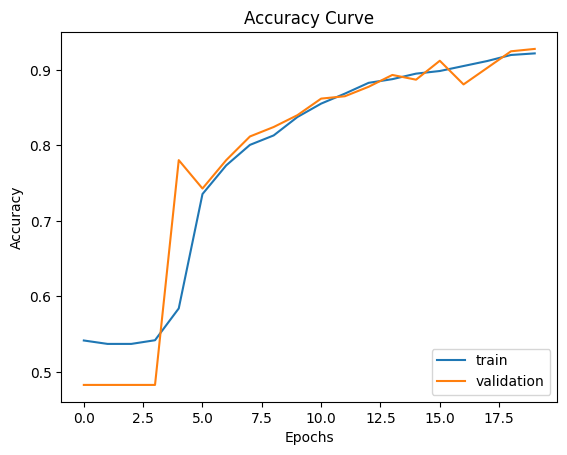

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curve')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

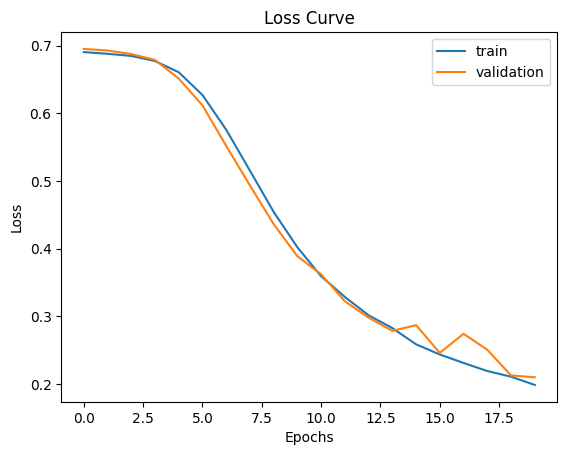

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()